<a href="https://colab.research.google.com/github/stalin99835/DUDL/blob/main/reg_unit_Untitled2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset



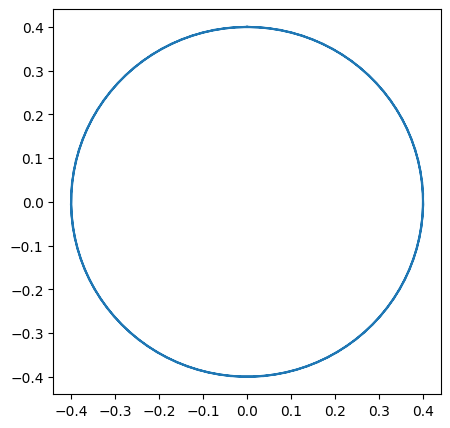

In [2]:
circle = np.linspace(0,4*np.pi,100)
radius = 0.4
a = radius*np.sin(circle)
b = radius*np.cos(circle)
#a = (radius*np.sin(circle),radius*np.cos(circle))
#print(a)
#data = np.hstack((a))
#print(data)
fig = plt.figure(figsize=(5,5))
plt.plot(a,b)
plt.show()

In [3]:
nPerClust = 200
th = np.linspace(0,4*np.pi,nPerClust)
r1 =10
r2 = 15
a = [r1*np.cos(th) + np.random.randn(nPerClust)*3,
     r1*np.sin(th) + np.random.randn(nPerClust)]
b = [r2*np.cos(th) + np.random.randn(nPerClust),
     r2*np.sin(th) + np.random.randn(nPerClust)*3]

#print(b)
#fig = plt.figure(figsize=(5,5))
#plt.plot(a,'ko')


#plt.show()


     #tru labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

#print(labels_np)

data_np = np.hstack((a,b)).T
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

#print(labels_np)

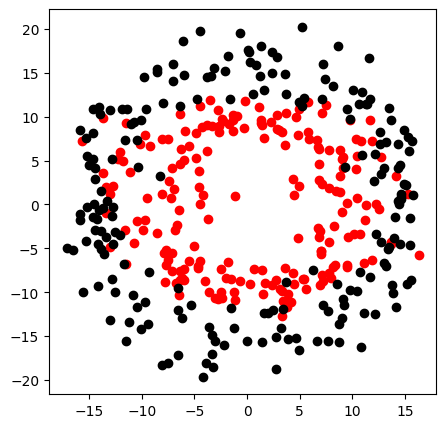

In [4]:
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'ro')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')

plt.show()

In [16]:
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=0.2)

train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)

#print(test_data.tensors[0].shape[0])


batch_size = 10

train_loader = DataLoader(train_data,batch_size,shuffle=True)

test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])


In [6]:
class theModelClass(nn.Module):
  def __init__(self,dropout_rate):
    super().__init__()

    #layers
    self.input = nn.Linear(2,128)
    self.hidden = nn.Linear(128,128)
    self.output = nn.Linear(128,1)

    self.dropout = dropout_rate

  def forward(self,x):
    x = F.relu(self.input(x))
    x = F.dropout(x,p=self.dropout,training=self.training)
    x = F.relu(self.hidden(x))
    x = F.dropout(x,p=self.dropout,training=self.training)
    x = self.output(x)
    return x


In [ ]:
tmpNet = theModelClass(0.5)
tmpData = torch.randn((10,2))
print(tmpData)


tensor([[ 1.6455, -0.6402],
        [-1.3693, -1.2198],
        [-1.3503, -1.3187],
        [ 0.5503, -0.2642],
        [-1.0239,  1.0552],
        [ 2.3677,  0.5112],
        [-1.1814,  1.0567],
        [-1.6079, -0.3066],
        [ 0.5071, -0.0762],
        [-2.0421, -0.8453]])


In [7]:
def createNewModel(dropout_rate):
  ANNQC = theModelClass(dropout_rate)
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(ANNQC.parameters(),lr=0.02)

  return ANNQC, lossfun, optimizer

In [21]:
numepochs = 1000

def trainTheModel(ANNQC,lossfun,optimiser):
  trainAcc = []
  testAcc = []



  for epochi in range(numepochs):
    batchAcc = []
    ANNQC.train()
    for X,y in train_loader:
      yHat = ANNQC(X)
      #print(yHat)
      loss = lossfun(yHat,y)

      optimiser.zero_grad()
      loss.backward()
      optimiser.step()

      batchAcc.append(100*torch.mean(((yHat>0.5)==y).float()).item())

    trainAcc.append(np.mean(batchAcc))

    #print(trainAcc)
    #test accuracy
    ANNQC.eval()
    X,y = next(iter(test_loader))
    yHat = ANNQC(X)
    testAcc.append(100*torch.mean(((yHat>0.5)==y).float()).item())

  return(trainAcc,testAcc)

In [22]:
dropout = 0
ANNQC,lossfun,optimiser = createNewModel(dropout)
trainAcc,testAcc = trainTheModel(ANNQC,lossfun,optimiser)

def smooth(x,k=5):
  return np.convolve(x,np.ones(k)/k,mode='same')



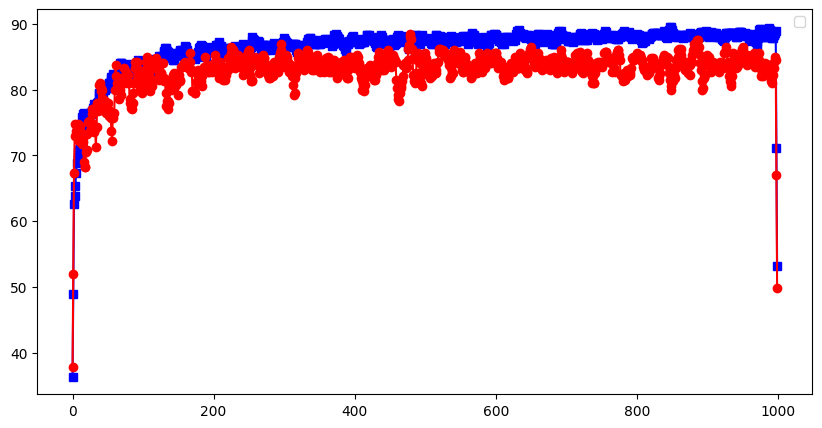

In [26]:
fig = plt.figure(figsize=(10,5))
plt.plot(smooth(trainAcc),'bs-')
plt.plot(smooth(testAcc),'ro-')
plt.legend()
plt.show()

In [44]:
dropoutrates = np.arange(10)/10
#print(dropoutrates)
results = np.zeros((len(dropoutrates),2))
#print(results)

for di in range(len(dropoutrates)):
  ANNQC,lossfun,optimiser = createNewModel(dropoutrates[di])
  trainAcc,testAcc = trainTheModel(ANNQC,lossfun,optimiser)
  #print(di)

  results[di,0] = trainAcc[-100]
  results[di,1] = testAcc[-100]

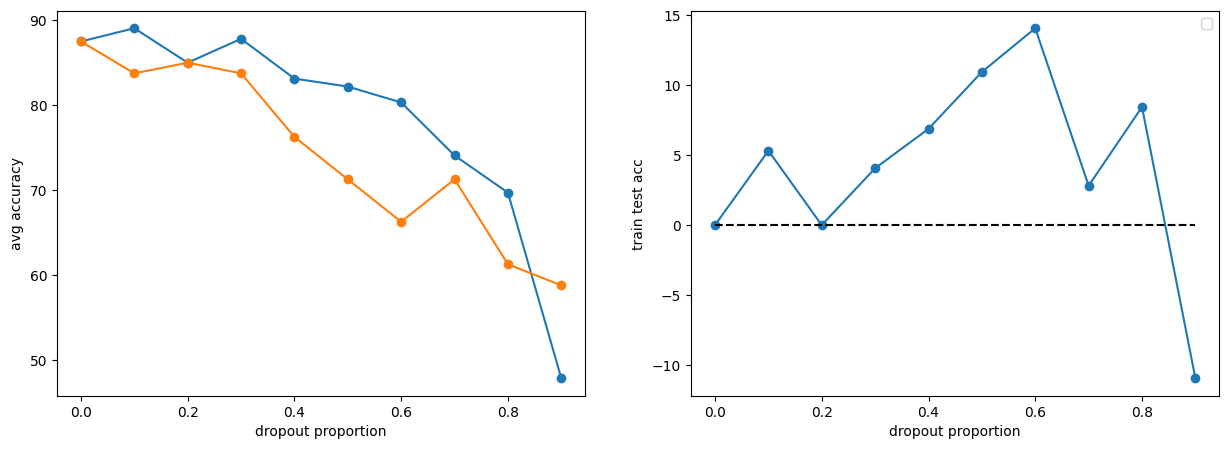

In [45]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(dropoutrates,results,'o-')
ax[0].set_xlabel('dropout proportion')
ax[0].set_ylabel('avg accuracy')


ax[1].plot(dropoutrates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('dropout proportion')
ax[1].set_ylabel('train test acc')

plt.legend()
plt.show()

#ax[0]plot(dropoutrates,results,'ro-')

#plt.legend()
#plt.show()

In [ ]:
prob = 0.5

dropout = nn.Dropout(p=prob)
x = torch.ones(10)

#dropout.eval()
y = F.dropout(x,p=prob,training=False)
print(x)
print(y)
print(torch.mean(y))
y = dropout(x)
print(x)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([2., 0., 0., 2., 0., 2., 2., 0., 2., 2.])
tensor(1.2000)


In [ ]:
iris = sns.load_dataset('iris')
data = torch.tensor(iris[iris.columns[0:4]].values).float()

labels = torch.zeros(len(data),dtype=torch.long)

labels[iris.species=='setosa'] = 0
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2


In [ ]:
propTraining = 0.8
nTraining = int(len(labels)*propTraining)

traintestBool = np.zeros(len(labels),dtype=bool)
print(traintestBool)
#traintestBool[range(nTraining)] = True
item2use4train = np.random.choice(range(len(labels)),nTraining,replace=False)
traintestBool[item2use4train] = True
print(traintestBool)
#print(np.where(traintestBool))

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]
[ True  True  True  True  True  True  True False False False  True False
  True  True 

In [ ]:
print('average all data')
print(torch.mean(labels.float()))
print(' ')

print('average of trainng data')
print(torch.mean(labels[traintestBool].float()))

print('average of test data')
print(torch.mean(labels[~traintestBool].float()))

average all data
tensor(1.)
 
average of trainng data
tensor(0.9917)
average of test data
tensor(1.0333)


In [ ]:
def createNewModel():
  ANNiris = nn.Sequential(
      nn.Linear(4,64),
      nn.ReLU(),
      nn.Linear(64,64),
      nn.ReLU(),
      nn.Linear(64,3),
  )

  lossfun = nn.CrossEntropyLoss()

  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=0.01)

  return ANNiris, lossfun, optimizer

In [ ]:
print(data.shape)
print(data[traintestBool].shape)
print(data[~traintestBool].shape)

torch.Size([150, 4])
torch.Size([120, 4])
torch.Size([30, 4])


In [ ]:
numepochs = 10
#trainProp = 0.8
def trainModel(trainProp):

  losses = torch.zeros(numepochs)
  trainAcc= []
  testAcc = []
  x_train,x_test,y_train,y_test = train_test_split(data,labels,train_size=trainProp)
  print(x_train.shape)
  print(x_test.shape)

  for epochi in range(numepochs):

    yHat = ANNiris(x_train)
    #ongoingAcc.append(100*torch.mean(
    #    (torch.argmax(yHat,axis=1)==labels[traintestBool]).float()))

    loss = lossfun(yHat,y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    trainAcc.append(100*torch.mean(
        (torch.argmax(yHat,axis=1)==y_train).float()).item())

    predLabels = torch.argmax(ANNiris(x_test),axis=1)
    testAcc.append(100*torch.mean((predLabels==y_test).float()).item())

  return(trainAcc,testAcc)



In [ ]:
ANNiris, lossfun, optimizer = createNewModel()

In [ ]:
trainAcc, testAcc = trainModel(.8)

torch.Size([120, 4])
torch.Size([30, 4])


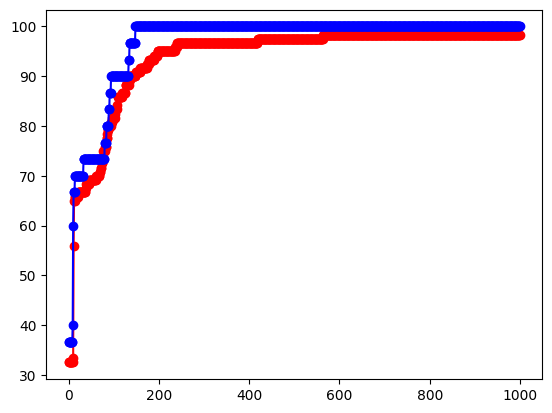

In [ ]:
plt.plot(trainAcc,'ro-')
plt.plot(testAcc,'bo-')
plt.show()

In [ ]:
numepochs = 1000
trainSetSizes = np.linspace(.2,.95,10)
allTrainAcc = np.zeros((len(trainSetSizes),numepochs))
allTestAcc = np.zeros((len(trainSetSizes),numepochs))

for i in range(len(trainSetSizes)):
  ANNiris, lossfun, optimizer = createNewModel()
  trainAcc, testAcc = trainModel(trainSetSizes[i])
  print(trainSetSizes[i])
  print(testAcc)
  print(len(testAcc))
  print(trainAcc)
  print(len(trainAcc))
  print('--------------')
  allTrainAcc[i,:] = trainAcc
  allTestAcc[i,:] = testAcc

  #print(trainAcc)
  #print('--------------')
  #print(testAcc)

0.2
[64.99999761581421, 64.99999761581421, 64.99999761581421, 64.99999761581421, 64.99999761581421, 64.99999761581421, 64.99999761581421, 64.99999761581421, 64.99999761581421, 64.99999761581421, 64.99999761581421, 64.99999761581421, 64.99999761581421, 64.99999761581421, 64.99999761581421, 64.99999761581421, 64.99999761581421, 64.99999761581421, 64.99999761581421, 64.99999761581421, 64.99999761581421, 64.99999761581421, 64.99999761581421, 64.99999761581421, 65.83333611488342, 66.66666865348816, 66.66666865348816, 69.9999988079071, 70.83333134651184, 70.83333134651184, 69.16666626930237, 69.16666626930237, 69.16666626930237, 71.66666388511658, 71.66666388511658, 71.66666388511658, 71.66666388511658, 71.66666388511658, 72.50000238418579, 74.16666746139526, 75.0, 75.0, 75.83333253860474, 75.83333253860474, 75.83333253860474, 77.49999761581421, 79.16666865348816, 79.16666865348816, 79.16666865348816, 79.16666865348816, 80.83333373069763, 80.83333373069763, 81.66666626930237, 81.666666269302

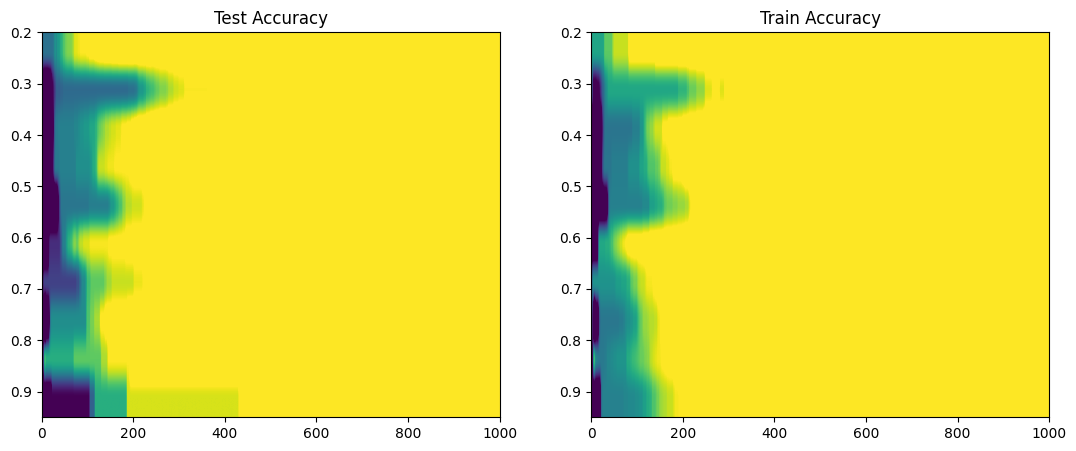

In [ ]:
#print(allTestAcc)
fig,ax = plt.subplots(1,2,figsize=(13,5))
ax[0].imshow(allTestAcc,aspect='auto',
             vmin=50,vmax=90,extent=[0,numepochs,trainSetSizes[-1],trainSetSizes[0]])

ax[1].imshow(allTrainAcc,aspect='auto',
             vmin=50,vmax=90,extent=[0,numepochs,trainSetSizes[-1],trainSetSizes[0]])

ax[0].set_title('Test Accuracy')
ax[1].set_title('Train Accuracy')

plt.show()

In [ ]:
fakedata = np.tile(np.array([1,2,3,4]),(10,1)) + np.tile(10*np.arange(1,11),(4,1)).T
print(fakedata)
fakelabels = np.arange(10)>4
print(fakelabels)


[[ 11  12  13  14]
 [ 21  22  23  24]
 [ 31  32  33  34]
 [ 41  42  43  44]
 [ 51  52  53  54]
 [ 61  62  63  64]
 [ 71  72  73  74]
 [ 81  82  83  84]
 [ 91  92  93  94]
 [101 102 103 104]]
[False False False False False  True  True  True  True  True]


In [ ]:
train_data,test_data,train_labels,test_labels = train_test_split(fakedata,fakelabels,test_size=0.2)